In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
file_path = 'EastWestAirlines.xlsx' 
df = pd.read_excel(file_path, sheet_name='data')
df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [3]:
print(df.shape)
print(df.columns.tolist())
print(df.isnull().sum())

(3999, 12)
['ID#', 'Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll', 'Award?']
ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64


In [5]:
if 'ID#' in df.columns:
 df = df.drop(columns=['ID#'])


# Rename any awkward column names (optional)
df = df.rename(columns={col: col.strip() for col in df.columns})


# Separate features and (if present) label
if 'Award?' in df.columns:
    y = df['Award?']
    X = df.drop(columns=['Award?'])
else:
    y = None
    X = df.copy()


X.describe().T

,count,mean,std,min,25%,50%,75%,max
Balance,3999.0,73601.327582,100775.664958,0.0,18527.5,43097.0,92404.0,1704838.0
Qual_miles,3999.0,144.114529,773.663804,0.0,0.0,0.0,0.0,11148.0
cc1_miles,3999.0,2.059515,1.376919,1.0,1.0,1.0,3.0,5.0
cc2_miles,3999.0,1.014504,0.147650,1.0,1.0,1.0,1.0,3.0
cc3_miles,3999.0,1.012253,0.195241,1.0,1.0,1.0,1.0,5.0
Bonus_miles,3999.0,17144.846212,24150.967826,0.0,1250.0,7171.0,23800.5,263685.0
Bonus_trans,3999.0,11.601900,9.603810,0.0,3.0,12.0,17.0,86.0
Flight_miles_12mo,3999.0,460.055764,1400.209171,0.0,0.0,0.0,311.0,30817.0
Flight_trans_12,3999.0,1.373593,3.793172,0.0,0.0,0.0,1.0,53.0
Days_since_enroll,3999.0,4118.559390,2065.134540,2.0,2330.0,4096.0,5790.5,8296.0


In [6]:
def count_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()


outlier_counts = {col: count_outliers_iqr(X[col]) for col in X.columns}
print('Outlier counts (IQR method):')
outlier_counts

Outlier counts (IQR method):


{'Balance': np.int64(266),
 'Qual_miles': np.int64(226),
 'cc1_miles': np.int64(0),
 'cc2_miles': np.int64(43),
 'cc3_miles': np.int64(18),
 'Bonus_miles': np.int64(280),
 'Bonus_trans': np.int64(63),
 'Flight_miles_12mo': np.int64(569),
 'Flight_trans_12': np.int64(565),
 'Days_since_enroll': np.int64(0)}

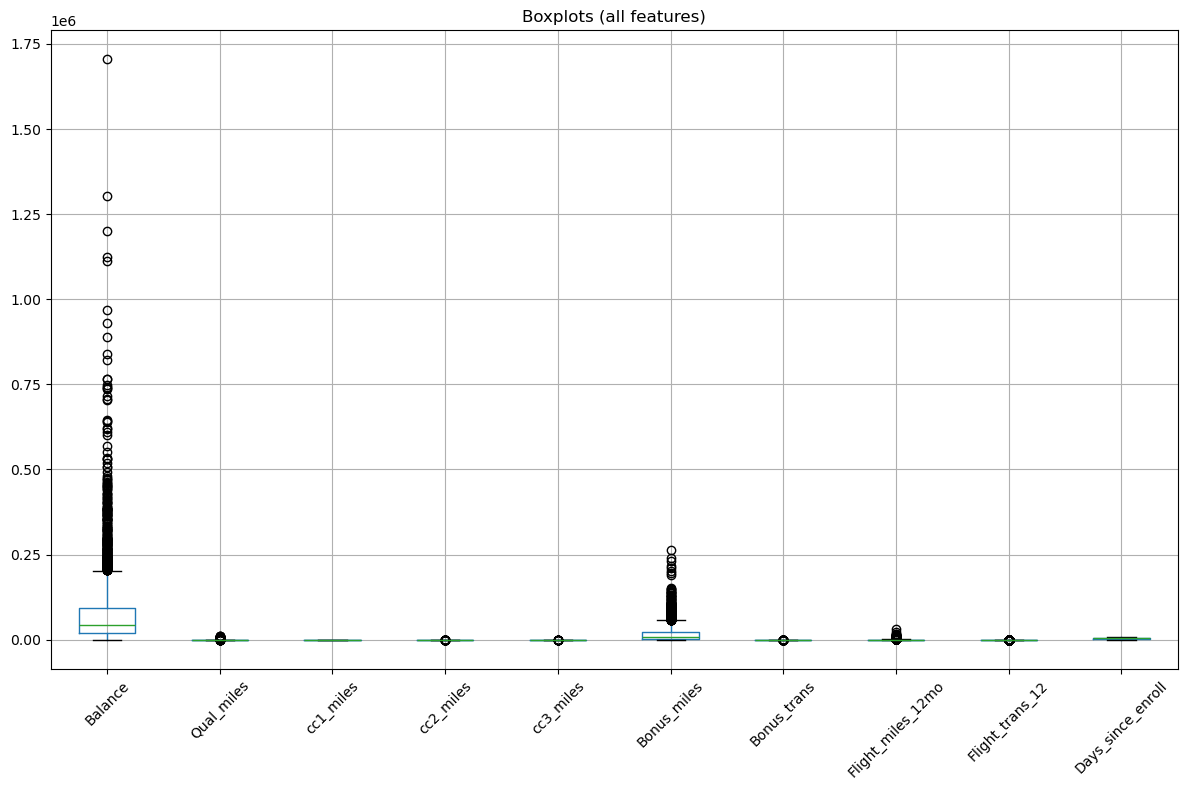

In [7]:
plt.figure(figsize=(12, 8))
X.boxplot(rot=45)
plt.title('Boxplots (all features)')
plt.tight_layout()
plt.show()

In [9]:
X_wins = X.copy()
for col in X_wins.columns:
    lower = X_wins[col].quantile(0.01)
    upper = X_wins[col].quantile(0.99)
    X_wins[col] = X_wins[col].clip(lower=lower, upper=upper)



X[['Balance']].describe()
X_wins[['Balance']].describe()

,Balance
count,3999.000000
mean,70953.687722
std,81922.405851
min,909.620000
25%,18527.500000
50%,43097.000000
75%,92404.000000
max,459757.260000


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_wins)
X_scaled = pd.DataFrame(X_scaled, columns=X_wins.columns)
X_scaled.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
0,-0.522641,-0.210071,-0.769578,-0.104257,0.0,-0.755753,-1.137866,-0.392821,-0.407834,1.396640
1,-0.631282,-0.210071,-0.769578,-0.104257,0.0,-0.753883,-1.029614,-0.392821,-0.407834,1.381123
2,-0.361359,-0.210071,-0.769578,-0.104257,0.0,-0.575651,-0.813110,-0.392821,-0.407834,1.413127
3,-0.685828,-0.210071,-0.769578,-0.104257,0.0,-0.740885,-1.137866,-0.392821,-0.407834,1.373364
4,0.327159,-0.210071,1.409471,-0.104257,0.0,1.211097,1.568432,1.536915,0.858660,1.365121


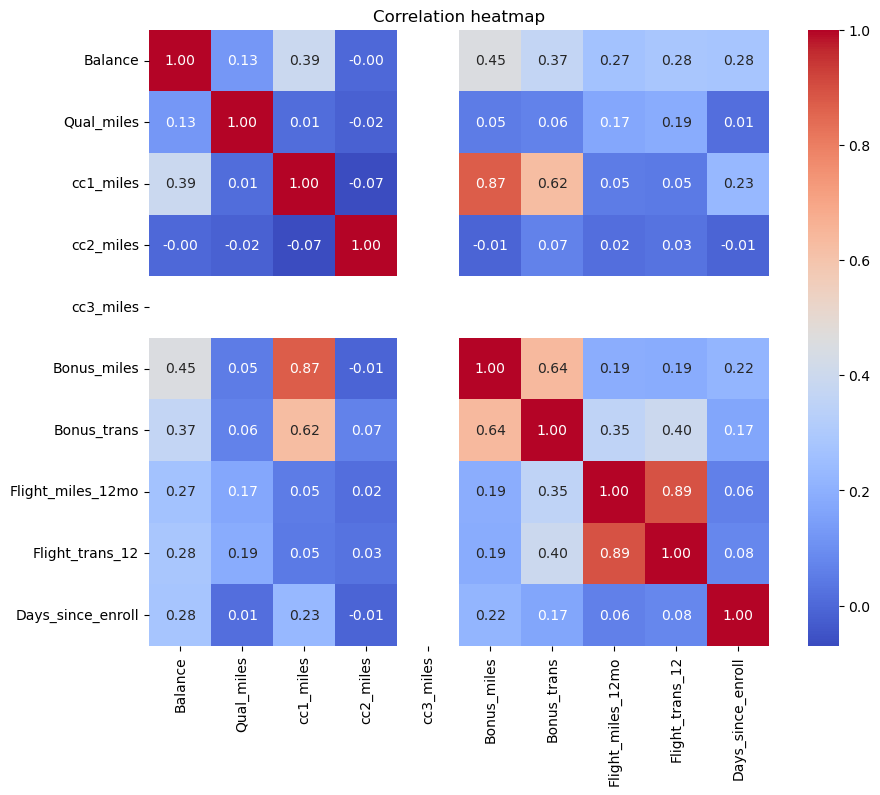

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_wins.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

<Figure size 1200x800 with 0 Axes>

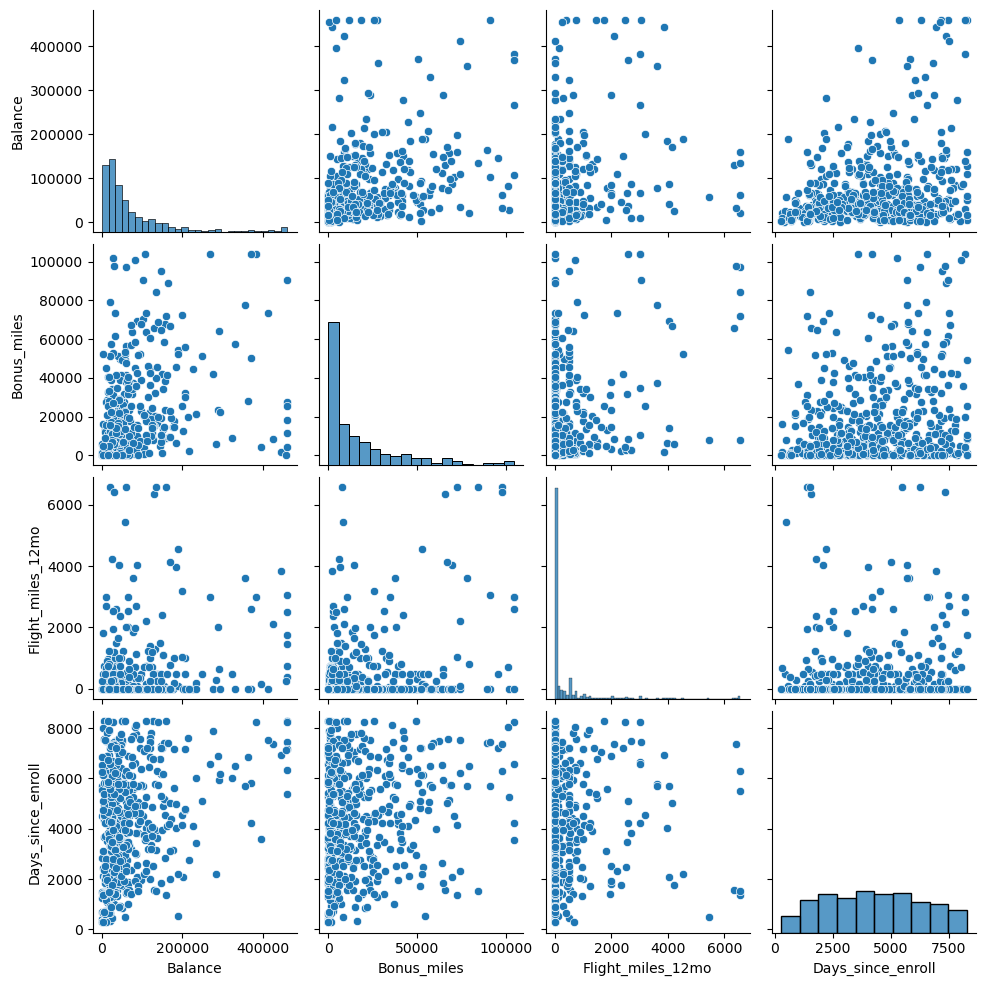

In [12]:
sample = X_wins.sample(n=500, random_state=42)
plt.figure(figsize=(12, 8))
_ = sns.pairplot(sample[[ 'Balance', 'Bonus_miles', 'Flight_miles_12mo', 'Days_since_enroll']])

Explained variance ratio (2 components): [0.35068867 0.1937433 ]


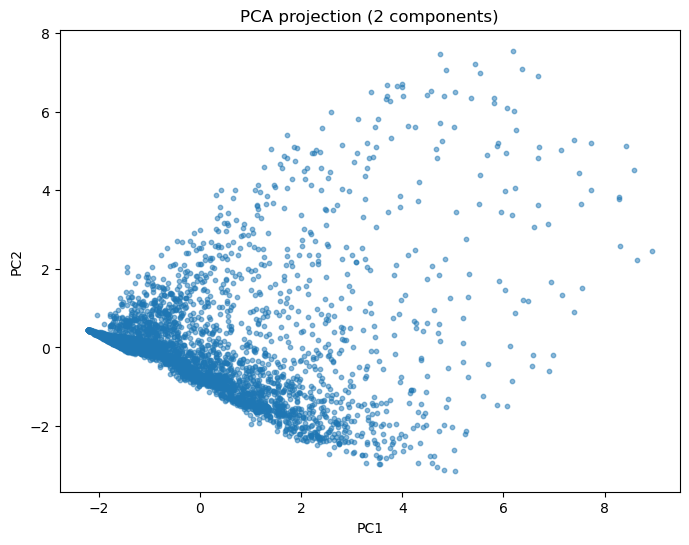

In [13]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print('Explained variance ratio (2 components):', pca.explained_variance_ratio_)


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection (2 components)')
plt.show()

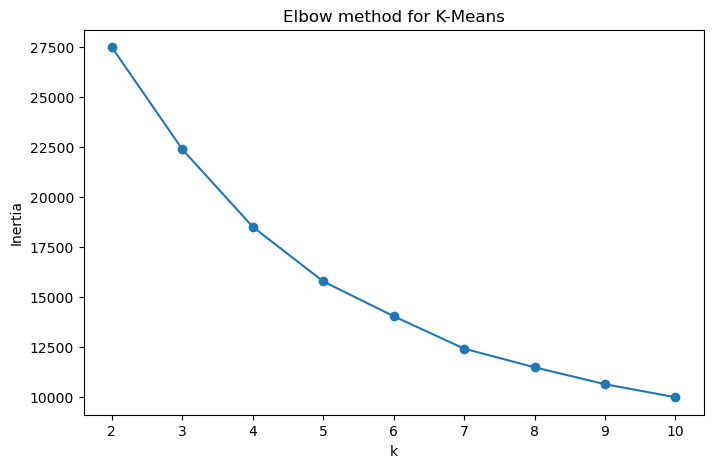

In [15]:
inertia = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method for K-Means')
plt.xticks(K_range)
plt.show()


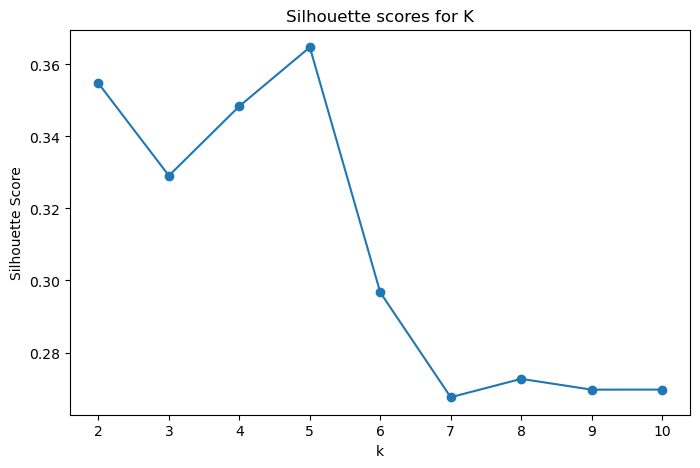

In [16]:
sil_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)


plt.figure(figsize=(8, 5))
plt.plot(K_range, sil_scores, '-o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette scores for K')
plt.xticks(K_range)
plt.show()

Best k by silhouette: 5


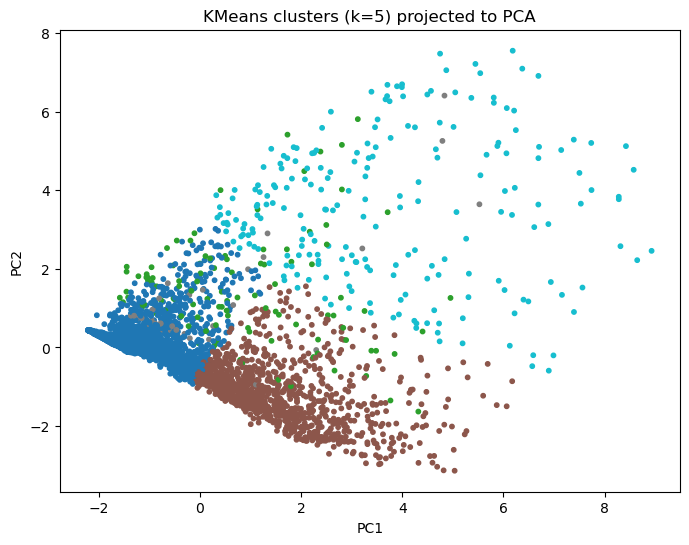

In [17]:
best_k = K_range[int(np.argmax(sil_scores))]
print('Best k by silhouette:', best_k)


# Fit final KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_km = kmeans.fit_predict(X_scaled)


# Attach labels and visualize on PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_km, cmap='tab10', s=10)
plt.title(f'KMeans clusters (k={best_k}) projected to PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [18]:
print('Silhouette score (KMeans):', silhouette_score(X_scaled, labels_km))

Silhouette score (KMeans): 0.3647665910357928


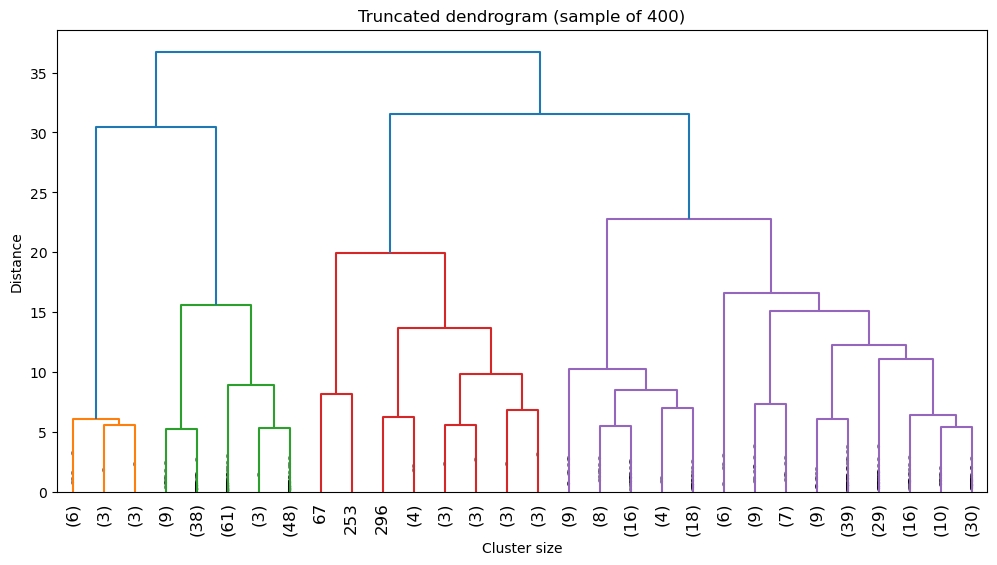

In [19]:
sample_for_dend = X_scaled.sample(n=400, random_state=42)
linked = linkage(sample_for_dend, method='ward')


plt.figure(figsize=(12, 6))
_ = dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.title('Truncated dendrogram (sample of 400)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

Silhouette score (Agglomerative): 0.3306372944806817


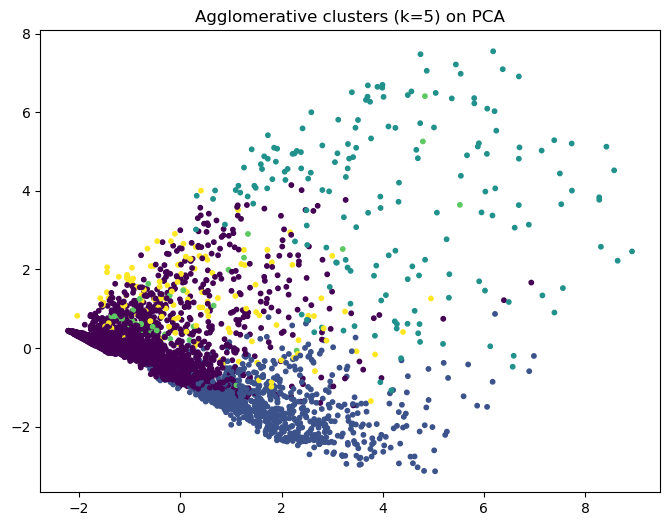

In [20]:
agg = AgglomerativeClustering(n_clusters=best_k)
labels_agg = agg.fit_predict(X_scaled)
print('Silhouette score (Agglomerative):', silhouette_score(X_scaled, labels_agg))


plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_agg, s=10)
plt.title(f'Agglomerative clusters (k={best_k}) on PCA')
plt.show()

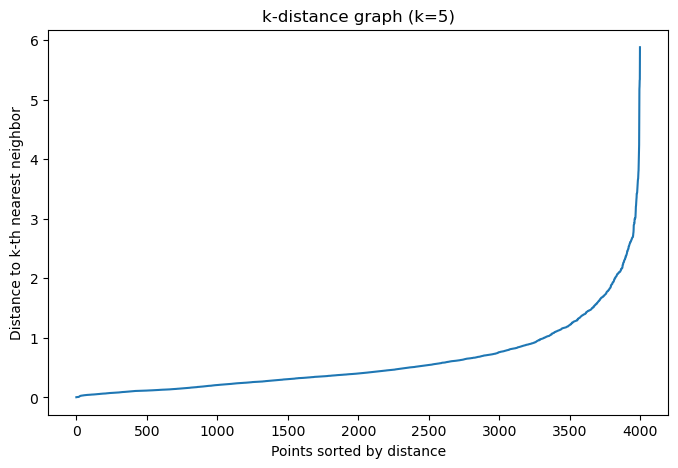

In [22]:
from sklearn.neighbors import NearestNeighbors


min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
# distances to kth neighbor
k_distances = np.sort(distances[:, -1])


plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.title('k-distance graph (k=5)')
plt.ylabel('Distance to k-th nearest neighbor')
plt.xlabel('Points sorted by distance')
plt.show()

In [23]:
eps_values = [0.8, 0.6, 1.0]
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels_db = db.fit_predict(X_scaled)
    n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    n_noise = list(labels_db).count(-1)
    sil = None
    if n_clusters > 1:
        try:
            sil = silhouette_score(X_scaled, labels_db)
        except Exception:
            sil = None
print(f'eps={eps}: clusters={n_clusters}, noise={n_noise}, silhouette={sil}')

eps=1.0: clusters=5, noise=539, silhouette=0.37052239294568007


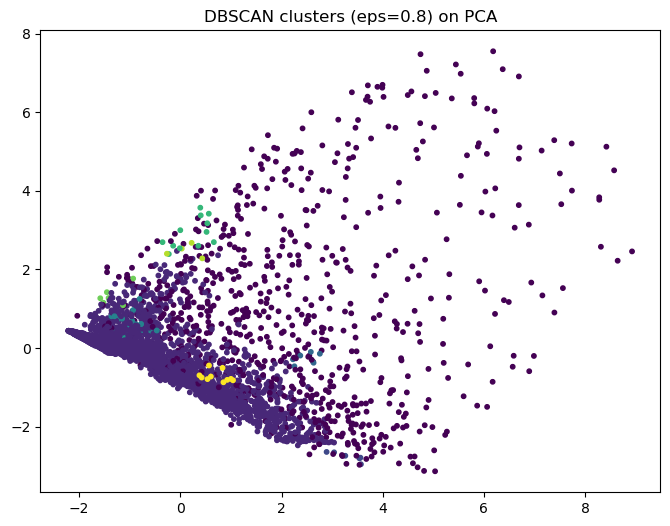

In [24]:
eps_chosen = 0.8
db = DBSCAN(eps=eps_chosen, min_samples=min_samples)
labels_db = db.fit_predict(X_scaled)


plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_db, s=10)
plt.title(f'DBSCAN clusters (eps={eps_chosen}) on PCA')
plt.show()

In [25]:
clustered = X_wins.copy()
clustered['KMeans_label'] = labels_km
clustered['Agg_label'] = labels_agg
clustered['DBSCAN_label'] = labels_db


print('KMeans cluster sizes:')
print(clustered['KMeans_label'].value_counts())
print('\nAgglomerative cluster sizes:')
print(clustered['Agg_label'].value_counts())
print('\nDBSCAN cluster sizes (including -1 as noise):')
print(clustered['DBSCAN_label'].value_counts())


# Summary statistics per cluster (KMeans)
print('\nKMeans cluster centers (in original feature space - approximate):')
centers_original_space = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_original_space, columns=X_wins.columns)
centers_df

KMeans cluster sizes:
KMeans_label
0    2357
2    1270
4     219
1     110
3      43
Name: count, dtype: int64

Agglomerative cluster sizes:
Agg_label
0    2693
1     955
2     170
4     138
3      43
Name: count, dtype: int64

DBSCAN cluster sizes (including -1 as noise):
DBSCAN_label
 0    3173
-1     753
 3      24
 5      12
 8      10
 2       6
 6       6
 1       6
 4       5
 7       4
Name: count, dtype: int64

KMeans cluster centers (in original feature space - approximate):


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
0,40178.397777,16.717437,1.181162,1.0,1.0,4134.059822,6.484955,162.876114,0.531608,3695.162164
1,97507.700000,3101.308182,2.018182,1.0,1.0,18356.475636,11.636364,654.436364,2.009091,4046.327091
2,111863.748126,20.875591,3.685827,1.0,1.0,37635.491559,18.383087,253.009449,0.757480,4848.049606
3,68876.581395,23.255814,1.139535,2.0,1.0,14689.837209,17.350698,582.627907,2.093023,3968.767442
4,152003.714703,351.530137,2.283105,1.0,1.0,30918.580822,24.547763,4057.121461,11.986301,4533.520548


In [26]:
km_summary = clustered.groupby('KMeans_label').mean()[['Balance', 'Flight_miles_12mo', 'Bonus_miles', 'Flight_trans_12', 'Days_since_enroll']]
km_summary


# If Award? existed, check distribution across clusters
if y is not None:
    clustered_with_award = clustered.copy()
    clustered_with_award['Award?'] = y.values
print('\nAward? distribution per KMeans cluster:')
print(clustered_with_award.groupby('KMeans_label')['Award?'].value_counts(normalize=True))


Award? distribution per KMeans cluster:
KMeans_label  Award?
0             0         0.768774
              1         0.231226
1             1         0.572727
              0         0.427273
2             1         0.543307
              0         0.456693
3             0         0.604651
              1         0.395349
4             1         0.757991
              0         0.242009
Name: proportion, dtype: float64


In [29]:
clustered.to_csv('EastWest_clusters.csv', index=False)
print('Saved clustered dataset EastWest_clusters.csv')

Saved clustered dataset EastWest_clusters.csv


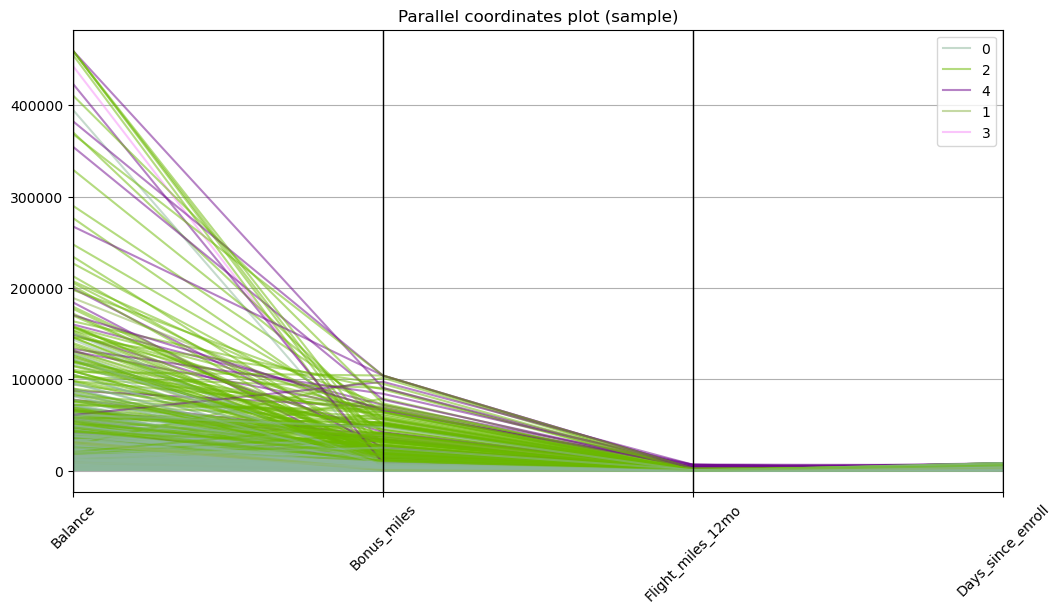

In [30]:
from pandas.plotting import parallel_coordinates


profile_df = clustered.copy()
profile_df['cluster'] = profile_df['KMeans_label'].astype(str)
# sample to make plot legible
sample_profile = profile_df.sample(n=400, random_state=42)
plt.figure(figsize=(12,6))
parallel_coordinates(sample_profile[['cluster'] + ['Balance', 'Bonus_miles', 'Flight_miles_12mo', 'Days_since_enroll']], 'cluster', alpha=0.5)
plt.title('Parallel coordinates plot (sample)')
plt.xticks(rotation=45)
plt.show()

Linkage=ward, Silhouette=0.331
Linkage=complete, Silhouette=0.447
Linkage=average, Silhouette=0.579
Linkage=single, Silhouette=0.644


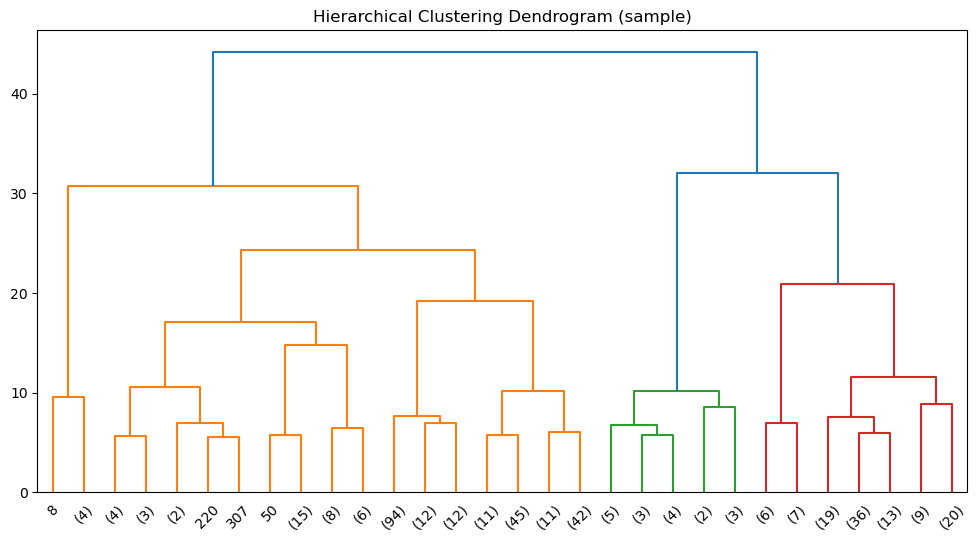

In [32]:
methods = ['ward', 'complete', 'average', 'single']
for method in methods:
    agg = AgglomerativeClustering(n_clusters=best_k, linkage=method)
    labels_agg = agg.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels_agg)
    print(f'Linkage={method}, Silhouette={sil:.3f}')


sample = X_scaled[:400]
linked = linkage(sample, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=30)
plt.title('Hierarchical Clustering Dendrogram (sample)')
plt.show()

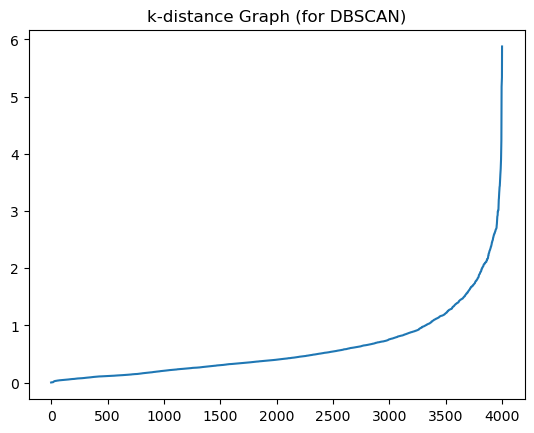

In [34]:
from sklearn.neighbors import NearestNeighbors


min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
k_distances = np.sort(distances[:, -1])


plt.plot(k_distances)
plt.title('k-distance Graph (for DBSCAN)')
plt.show()

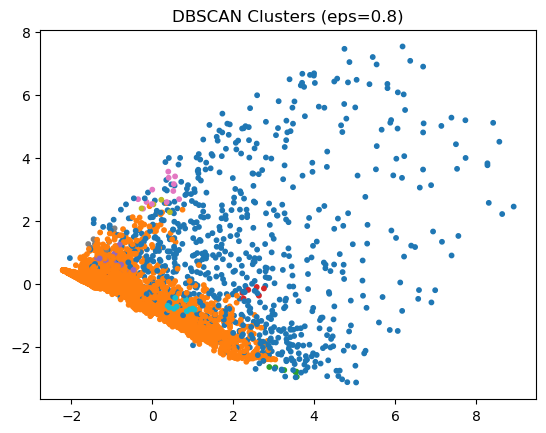

In [35]:
eps_values = [0.5, 0.8, 1.0]
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels_db = db.fit_predict(X_scaled)
    n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    n_noise = list(labels_db).count(-1)
    if n_clusters > 1:
        sil = silhouette_score(X_scaled, labels_db)
    else:
        sil = None
        print(f'eps={eps}, clusters={n_clusters}, noise={n_noise}, silhouette={sil}')


chosen_eps = 0.8
db = DBSCAN(eps=chosen_eps, min_samples=min_samples)
labels_db = db.fit_predict(X_scaled)


plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_db, cmap='tab10', s=10)
plt.title(f'DBSCAN Clusters (eps={chosen_eps})')
plt.show()

In [36]:

if len(set(labels_db)) > 1:
    print("\nDBSCAN Evaluation Metrics:")
    print("Silhouette Score:", silhouette_score(X_scaled, labels_db))
    print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, labels_db))
    print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, labels_db))


DBSCAN Evaluation Metrics:
Silhouette Score: -0.132277635823381
Davies-Bouldin Index: 1.5533018637660125
Calinski-Harabasz Index: 144.26870752976984


In [33]:
print('\nCluster Sizes:')
print('KMeans:', pd.Series(labels_km).value_counts().to_dict())
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
labels_agg = agg.fit_predict(X_scaled)
print('Agglomerative:', pd.Series(labels_agg).value_counts().to_dict())
print('DBSCAN:', pd.Series(labels_db).value_counts().to_dict())


Cluster Sizes:
KMeans: {0: 2357, 2: 1270, 4: 219, 1: 110, 3: 43}
Agglomerative: {0: 2693, 1: 955, 2: 170, 4: 138, 3: 43}
DBSCAN: {0: 3173, -1: 753, 3: 24, 5: 12, 8: 10, 2: 6, 6: 6, 1: 6, 4: 5, 7: 4}
